### Using image augmentation : 
by applying affine (rotation, scalingand horizontal shearing) and elastic deformations

Drawing inspiration from https://arxiv.org/pdf/1003.0358.pdf

In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

In [2]:
def plot_loss_accuracy(history):
    '''
    A function to plot train and validation loss against epochs of training
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [50]:
# using ImageDataGenerator to load data from the disk

train_data_path = 'gurumukhi_digits_dataset/train'
val_data_path = 'gurumukhi_digits_dataset/val'

IMAGE_SIZE = 32
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1) # 3 channels
NUM_OF_CLASSES = 10

ROTATION_RANGE = 15 # in degree 
SHEAR_RANGE = 15 # in degree 


# Adding random rotation and shear
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range= ROTATION_RANGE,
    shear_range=  SHEAR_RANGE,
    # preprocessing_function= lambda img: np.where(img < 1, 0.0, 1.0), # converting fractions to 0
    fill_mode= 'constant', 
    cval= 255.0 # filling white values
    )

val_image_generator = ImageDataGenerator( rescale=1./255 ) # no deformations for validation data

train_data_gen = train_image_generator.flow_from_directory(
    train_data_path, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='grayscale', # for 1 channel images
    class_mode='sparse', # labels will be integers
    batch_size=32, 
    shuffle=True, 
    seed=None,
    )

val_data_gen = val_image_generator.flow_from_directory(
    val_data_path, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='grayscale', # for 1 channel images
    class_mode='sparse', # labels will be integers
    batch_size=32, 
    shuffle=True, 
    seed=None,
    )


Found 1000 images belonging to 10 classes.
Found 178 images belonging to 10 classes.


shape of a batch given by image data generator : (32, 32, 32)


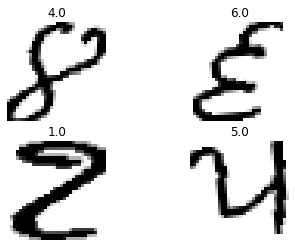

In [51]:
# checking/ validating some images generated by datagenerator

# This function will plot 4 images along with their labels.
def plotImages(image_datas,y_list):
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(image_datas[0], cmap='gray')
    axarr[0,0].set_title(y_list[0])
    axarr[0,0].axis('off')
    axarr[0,1].imshow(image_datas[1], cmap='gray')
    axarr[0,1].set_title(y_list[1])
    axarr[0,1].axis('off')
    axarr[1,0].imshow(image_datas[2], cmap='gray')
    axarr[1,0].set_title(y_list[2])
    axarr[1,0].axis('off')
    axarr[1,1].imshow(image_datas[3], cmap='gray')
    axarr[1,1].set_title(y_list[3])
    axarr[1,1].axis('off')

sample_training_images, y_list = next(train_data_gen)
sample_training_images = np.squeeze(sample_training_images) # to reduce dimension
print("shape of a batch given by image data generator : {}".format(sample_training_images.shape))

plotImages(sample_training_images[:4],y_list[:4])

### TODO : may need to convert fractions to zero or 1

In [61]:
# Trying a simple 1 layer NN : to get a baseline 
# TODO : make some variables to define learning rate, optimizer, etc. 

def create_1_layer_NN():
    model = tf.keras.models.Sequential([
        layers.Flatten(input_shape = IMAGE_SHAPE),
        layers.Dense(NUM_OF_CLASSES, activation='softmax') 
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [62]:
one_layer_NN_model = create_1_layer_NN()
one_layer_NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________


In [63]:
# training

one_layer_NN_checkpoint_filepath = 'one_layer_NN/checkpoint/'
one_layer_NN_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=one_layer_NN_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

one_layer_NN_model_history = one_layer_NN_model.fit(train_data_gen, epochs=100, 
                    validation_data=val_data_gen,
                    callbacks=[one_layer_NN_checkpoint_callback])

Epoch 1/100
32/32 [==============================] - 1s 40ms/step - loss: 1.8609 - accuracy: 0.3700 - val_loss: 1.3346 - val_accuracy: 0.5449
Epoch 2/100
32/32 [==============================] - 1s 37ms/step - loss: 0.9207 - accuracy: 0.7800 - val_loss: 0.8560 - val_accuracy: 0.7191
Epoch 3/100
32/32 [==============================] - 1s 38ms/step - loss: 0.6382 - accuracy: 0.8270 - val_loss: 0.6472 - val_accuracy: 0.7921
Epoch 4/100
32/32 [==============================] - 1s 44ms/step - loss: 0.4831 - accuracy: 0.8950 - val_loss: 0.4877 - val_accuracy: 0.8764
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 0.4290 - accuracy: 0.8850 - val_loss: 0.4578 - val_accuracy: 0.8652
Epoch 6/100
32/32 [==============================] - 1s 37ms/step - loss: 0.3509 - accuracy: 0.9190 - val_loss: 0.4097 - val_accuracy: 0.8652
Epoch 7/100
32/32 [==============================] - 1s 35ms/step - loss: 0.3342 - accuracy: 0.9150 - val_loss: 0.3602 - val_accuracy: 0.8933
Epoch 

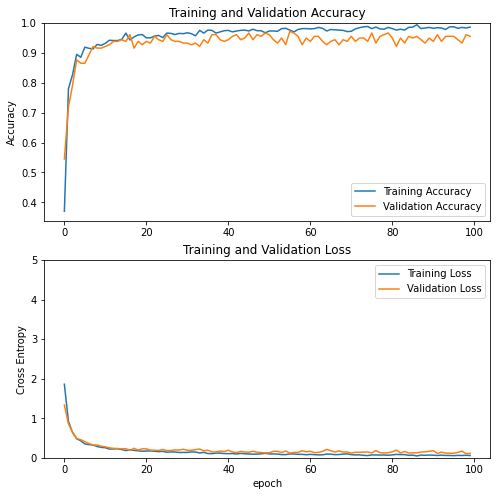

In [64]:
plot_loss_accuracy(one_layer_NN_model_history)

In [65]:
# checking the model with saved weights by evaluating on validation data
one_layer_NN_checkpoint_filepath = 'one_layer_NN/checkpoint/'

one_layer_NN_model.load_weights(one_layer_NN_checkpoint_filepath)
one_layer_NN_model.evaluate(val_data_gen)

6/6 [==============================] - 0s 32ms/step - loss: 0.1210 - accuracy: 0.9719


[0.12095910310745239, 0.9719101190567017]

## Observations with 1 layer NN (i.e. no hidden layer) with image augmentation
* Less overfitting than the one without image augmentation
* Better validation accuracy (97.19%) for best weights, but hovered around 96% (similar to w/o augmentation)
* Lower loss validation dataset when compared with the one w/o image augmentation

### Now trying hidden layers 

In [136]:
# Trying NN with 1 hidden layer

def create_1_hidden_layer_NN():
    model = tf.keras.models.Sequential([
        layers.Flatten(input_shape = IMAGE_SHAPE),
        layers.Dense(2048, activation='relu'),
        layers.Dense(NUM_OF_CLASSES, activation='softmax') 
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [131]:
one_hidden_layer_NN = create_1_hidden_layer_NN()
one_hidden_layer_NN.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_38 (Dense)             (None, 10)                5130      
Total params: 529,930
Trainable params: 529,930
Non-trainable params: 0
_________________________________________________________________


In [132]:
# training

one_hidden_layer_NN_checkpoint_filepath = 'one_hidden_layer_NN/checkpoint/'
one_hidden_layer_NN_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=one_hidden_layer_NN_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


one_hidden_layer_NN_history = one_hidden_layer_NN.fit(train_data_gen, epochs=64, 
                    validation_data=val_data_gen,
                    callbacks=[one_hidden_layer_NN_checkpoint_callback])

Epoch 1/64
32/32 [==============================] - 1s 43ms/step - loss: 1.6630 - accuracy: 0.5210 - val_loss: 0.7058 - val_accuracy: 0.7753
Epoch 2/64
32/32 [==============================] - 1s 42ms/step - loss: 0.5051 - accuracy: 0.8390 - val_loss: 0.3571 - val_accuracy: 0.8483
Epoch 3/64
32/32 [==============================] - 1s 44ms/step - loss: 0.3636 - accuracy: 0.8950 - val_loss: 0.2151 - val_accuracy: 0.9551
Epoch 4/64
32/32 [==============================] - 1s 38ms/step - loss: 0.2552 - accuracy: 0.9240 - val_loss: 0.2284 - val_accuracy: 0.9326
Epoch 5/64
32/32 [==============================] - 1s 39ms/step - loss: 0.2204 - accuracy: 0.9340 - val_loss: 0.1710 - val_accuracy: 0.9607
Epoch 6/64
32/32 [==============================] - 1s 37ms/step - loss: 0.2248 - accuracy: 0.9300 - val_loss: 0.1978 - val_accuracy: 0.9270
Epoch 7/64
32/32 [==============================] - 1s 42ms/step - loss: 0.1692 - accuracy: 0.9490 - val_loss: 0.2514 - val_accuracy: 0.9326
Epoch 8/64
32

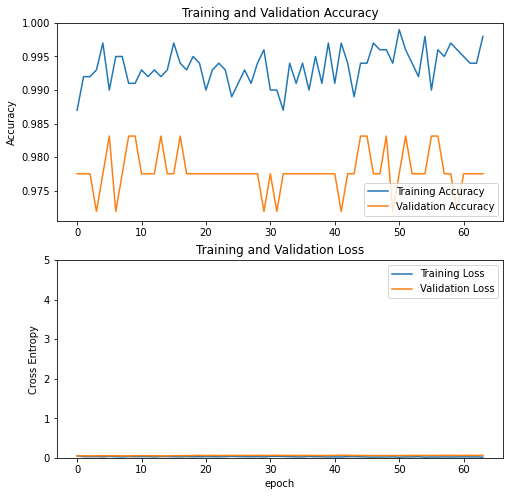

In [137]:
plot_loss_accuracy(one_hidden_layer_NN_history)

In [138]:
one_hidden_layer_NN_checkpoint_filepath = 'one_hidden_layer_NN/checkpoint/'

one_hidden_layer_NN.load_weights(one_hidden_layer_NN_checkpoint_filepath)
one_hidden_layer_NN.evaluate(val_data_gen)

6/6 [==============================] - 0s 35ms/step - loss: 0.0509 - accuracy: 0.9831


[0.05090147629380226, 0.983146071434021]

## Observations for 1 hidden layer NN :

Hidden layer with 5 units : 
* Poor learner : heavy underfitting
* Training and validation accuracy : 50-60%

Hidden layer with 10 units :
* Better learner than the one with 5 units : but still a poor lerarner
* Slight overfitting : Training accuracy reaches 90% but validation accuracy reaches ~85-88%
* Worse performer than 1-Layer-NN with no hidden layer

Hidden layer with 16 units :
* Performs better than the one with 10 units
* Negligible overfitting : Training and validation accuracy reaches ~96%
* Still no improvement over 1-Layer-NN with no hidden layer in validation accuracy but better in overfitting

Hidden layer with 32 units :
* Performs slightly better than 16 units
* Slight overfitting : training accuracy : 98% validation accuracy: 97.12% : in best case

Hidden layer with 64 units :
* Almost no overfitting for first 50 epochs
* Best weights : validation accuracy: 97.75% and no overfit (epoch 32)

Hidden layer with 512 units : **BEST YET**
* Very Less overfitting for first 50 epochs
* Best weights : validation accuracy: 98.31% and no overfit (train acc = 98.20%)

Hidden layer with >512 units : perform very similar to the 512 units one
* Diminishing return : i.e. no point in using layers wider than 512




### Now trying multiple hidden layers 

In [184]:
# now trying NN with multiple hidden layers

def create_multi_hidden_layer_NN():
    model = tf.keras.models.Sequential([
        layers.Flatten(input_shape = IMAGE_SHAPE),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(NUM_OF_CLASSES, activation='softmax') 
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [185]:
multi_hidden_layer_NN = create_multi_hidden_layer_NN()
multi_hidden_layer_NN.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_75 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_76 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_77 (Dense)             (None, 10)                5130      
Total params: 2,629,130
Trainable params: 2,629,130
Non-trainable params: 0
_________________________________________________________________


In [186]:
# training

multi_hidden_layer_NN_checkpoint_filepath = 'multi_hidden_layer_NN/checkpoint/'
multi_hidden_layer_NN_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=multi_hidden_layer_NN_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

multi_hidden_layer_NN_checkpoint_filepath_history = multi_hidden_layer_NN.fit(train_data_gen, epochs=50, 
                    validation_data=val_data_gen,
                    callbacks=[multi_hidden_layer_NN_checkpoint_callback])

Epoch 1/50
32/32 [==============================] - 2s 73ms/step - loss: 1.6062 - accuracy: 0.5140 - val_loss: 0.8654 - val_accuracy: 0.7079
Epoch 2/50
32/32 [==============================] - 2s 63ms/step - loss: 0.5260 - accuracy: 0.8300 - val_loss: 0.3604 - val_accuracy: 0.8933
Epoch 3/50
32/32 [==============================] - 2s 65ms/step - loss: 0.3811 - accuracy: 0.8810 - val_loss: 0.2816 - val_accuracy: 0.9270
Epoch 4/50
32/32 [==============================] - 2s 54ms/step - loss: 0.2976 - accuracy: 0.8970 - val_loss: 0.3495 - val_accuracy: 0.8483
Epoch 5/50
32/32 [==============================] - 2s 56ms/step - loss: 0.2437 - accuracy: 0.9210 - val_loss: 0.3532 - val_accuracy: 0.8876
Epoch 6/50
32/32 [==============================] - 2s 53ms/step - loss: 0.3476 - accuracy: 0.8840 - val_loss: 0.3070 - val_accuracy: 0.8764
Epoch 7/50
32/32 [==============================] - 2s 64ms/step - loss: 0.2234 - accuracy: 0.9200 - val_loss: 0.1887 - val_accuracy: 0.9438
Epoch 8/50
32

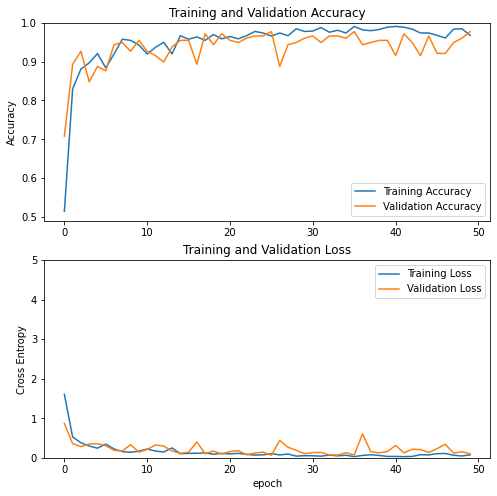

In [187]:
plot_loss_accuracy(multi_hidden_layer_NN_checkpoint_filepath_history)

In [188]:
multi_hidden_layer_NN_checkpoint_filepath = 'multi_hidden_layer_NN/checkpoint/'

multi_hidden_layer_NN.load_weights(multi_hidden_layer_NN_checkpoint_filepath)
multi_hidden_layer_NN.evaluate(val_data_gen)
multi_hidden_layer_NN.evaluate(train_data_gen)

32/32 [==============================] - 1s 29ms/step - loss: 0.0732 - accuracy: 0.9760


[0.07315844297409058, 0.9760000109672546]

### Some observations : no/ very less overfitting

*   (16,16) : val accuracy : 97.19% 
*   (512, 512) : val accuracy : 98.31% (train  99.40%)
*   (1024, 512) : val accuracy : 97.75% (train  97.00%)
*   (1024, 1024) : val accuracy : 98.88% (train  98.70%)
*   (1024, 1024, 512) : val accuracy : 97.75% (train  97.60%)
*   (1500, 1000, 500) : val accuracy : 98.31% (train  97.60%)
*   (2000, 1500, 1000, 500) : val accuracy : 98.31% (train  98.40%)